# 📊 Model Comparison: Pre-trained vs Fine-tuned

So sánh CLIP model trước và sau khi fine-tune với adversarial training.

**Test trên:** CIFAR-100 validation set  
**Metrics:** Clean Accuracy & Robust Accuracy (PGD attack)

## 1️⃣ Setup

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import clip
import sys
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append(str(Path(__file__).parent if '__file__' in globals() else Path.cwd()))

# Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_SAMPLES = 100
PGD_EPSILON = 2/255  # eps_pixel = 2
PGD_STEPS = 3        # steps = 3
PGD_ALPHA = 1.0/255  # alpha_pixel = 1.0

print(f"🖥️  Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

🖥️  Device: cpu


## 2️⃣ Load Dataset

In [12]:
from torchvision.datasets import CIFAR100

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CIFAR100(root="data", train=True, download=True, transform=transform)
class_to_idx = train_dataset.class_to_idx
val_dataset = CIFAR100(root="data", train=False, download=True, transform=transform)
val_indices = list(range(NUM_SAMPLES))
from torch.utils.data import Subset
val_subset = Subset(val_dataset, val_indices)
val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if DEVICE == "cuda" else False
)

print(f"✅ CIFAR-100 loaded: {NUM_SAMPLES} validation samples, {len(class_to_idx)} classes")

Files already downloaded and verified
Files already downloaded and verified
✅ CIFAR-100 loaded: 100 validation samples, 100 classes


## 3️⃣ Load Models

In [13]:
# Image preprocessing
ImageNet_MEAN = (0.485, 0.456, 0.406)
ImageNet_STD = (0.229, 0.224, 0.225)
mu_img = torch.tensor(ImageNet_MEAN, device=DEVICE).view(3, 1, 1)
std_img = torch.tensor(ImageNet_STD, device=DEVICE).view(3, 1, 1)

def clip_img_preprocessing(x):
    x = F.interpolate(x, size=(224, 224), mode='bicubic', align_corners=False)
    return (x - mu_img) / std_img

def convert_models_to_fp32(model):
    for p in model.parameters():
        if p.dtype == torch.float16:
            p.data = p.data.float()
            if p.grad is not None:
                p.grad.data = p.grad.data.float()
    return model

# Load Pre-trained CLIP (dùng checkpoint baseline_null_patch_30_cifar100)
baseline_ckpt_dir = Path("pt_models/")
baseline_ckpt_path = baseline_ckpt_dir / "cosine_loss_cifar100_20251221_064917.pth.tar"
pretrained_model, _ = clip.load("ViT-B/32", device=DEVICE, jit=False)
convert_models_to_fp32(pretrained_model)
if baseline_ckpt_path.exists():
    print(f"   ✅ Found baseline checkpoint: {baseline_ckpt_path}")
    baseline_ckpt = torch.load(str(baseline_ckpt_path), map_location=DEVICE, weights_only=False)
    pretrained_model.visual.load_state_dict(baseline_ckpt["vision_encoder_state_dict"])
    pretrained_model.eval()
    print("   ✅ Baseline CLIP loaded")
else:
    print(f"   ⚠️  Baseline checkpoint not found: {baseline_ckpt_path}")
    print("   Will use original pre-trained CLIP")

# Load Fine-tuned model (dùng checkpoint wangsibo_null_patch_30_cifar10)
finetuned_ckpt_dir = Path("pt_models/")
finetuned_ckpt_path = finetuned_ckpt_dir / "cosine_loss_cifar100_20251221_064917.pth.tar"
finetuned_model = None
if finetuned_ckpt_path.exists():
    print(f"   ✅ Found fine-tuned checkpoint: {finetuned_ckpt_path}")
    finetuned_model, _ = clip.load("ViT-B/32", device=DEVICE, jit=False)
    convert_models_to_fp32(finetuned_model)
    finetuned_ckpt = torch.load(str(finetuned_ckpt_path), map_location=DEVICE, weights_only=False)
    finetuned_model.visual.load_state_dict(finetuned_ckpt["vision_encoder_state_dict"])
    finetuned_model.eval()
    print("   ✅ Fine-tuned model loaded")
else:
    print(f"   ⚠️  Fine-tuned checkpoint not found: {finetuned_ckpt_path}")
    print("   Will compare with pretrained model only")

# Prepare text features for CIFAR-100
cifar100_classes = train_dataset.classes
prompts = [f"This is a photo of a {name}" for name in cifar100_classes]
tokens = clip.tokenize(prompts).to(DEVICE)

with torch.no_grad():
    text_features = pretrained_model.encode_text(tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

print(f"\n✅ Text features ready for {len(cifar100_classes)} classes")

   ✅ Found baseline checkpoint: pt_models\cosine_loss_cifar100_20251221_064917.pth.tar
   ✅ Baseline CLIP loaded
   ✅ Found fine-tuned checkpoint: pt_models\cosine_loss_cifar100_20251221_064917.pth.tar
   ✅ Fine-tuned model loaded

✅ Text features ready for 100 classes


## 4️⃣ PGD Attack

In [14]:
# --- Cell 4: PGD Attack Function ---

# Đảm bảo hàm preprocessing được định nghĩa (nếu chưa có thì dùng lại clip_img_preprocessing)
if 'pmg_img_preprocessing' not in globals():
    pmg_img_preprocessing = clip_img_preprocessing

def create_attack(model, image, text_features_all, target_idx, epsilon, step_size, device, dummy_prompt=None, steps=10):
    if epsilon == 0: return image.clone().detach()
    
    x0 = image.clone().detach().float()
    delta = torch.zeros_like(x0, device=device)
    delta.uniform_(-epsilon, epsilon)
    delta.requires_grad_(True)
    
    # Chuẩn hóa text features trước vòng lặp để tối ưu tốc độ
    text_features_all = text_features_all / text_features_all.norm(dim=-1, keepdim=True)

    for _ in range(steps):
        x_in = x0 + delta
        
        # Lưu ý: model.encode_image cần hỗ trợ tham số dummy_prompt nếu model là PMG-AFT custom.
        # Nếu dùng CLIP gốc, có thể sẽ cần bỏ tham số dummy_prompt.
        try:
            img_emb = model.encode_image(pmg_img_preprocessing(x_in), dummy_prompt)
        except TypeError:
            # Fallback nếu model là CLIP chuẩn không nhận dummy_prompt
            img_emb = model.encode_image(pmg_img_preprocessing(x_in))

        img_norm = img_emb / img_emb.norm(dim=-1, keepdim=True)
        
        # Tính logits
        logits = img_norm @ text_features_all.T
        
        # Với CLIP, ta muốn tấn công để model KHÔNG dự đoán đúng target_idx
        # Hàm loss này đang tối ưu để giảm xác suất của nhãn đúng => Untargeted Attack
        # Tuy nhiên PGD gốc thường maximize loss. 
        # Code bạn gửi đang thực hiện: delta = delta + step * sign(grad).
        # Grad từ loss.backward() sẽ hướng về phía tăng loss (làm sai lệch dự đoán).
        loss = F.cross_entropy(logits, target_idx)
        
        model.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            grad = delta.grad.detach()
            # Cập nhật delta
            delta.data = torch.clamp(delta + step_size * torch.sign(grad), -epsilon, epsilon)
            # Clip ảnh để nằm trong khoảng hợp lệ [0, 1] so với ảnh gốc
            delta.data = torch.clamp(delta, -x0, 1.0 - x0)
            delta.grad.zero_()
            
    return (x0 + delta).detach()

print("✅ New create_attack function ready")

✅ New create_attack function ready


## 5️⃣ Evaluate Models

In [15]:
# --- Cell 5: Evaluate Models ---

def evaluate_model(model, dataloader, attack=False):
    """Evaluate model accuracy with updated attack function"""
    model.eval()
    correct = 0
    total = 0
    
    desc = "PGD Attack" if attack else "Clean Eval"
    
    # Text features global đã được tính ở Cell 3
    global text_features
    
    for images, labels in tqdm(dataloader, desc=desc):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Apply PGD attack if needed
        if attack:
            # Tạo ảnh adversarial bằng hàm mới
            # Lưu ý: PGD_ALPHA trong config tương đương step_size
            # PGD_EPSILON tương đương epsilon
            # dummy_prompt để None hoặc tensor tùy vào kiến trúc model của bạn
            images = create_attack(
                model=model,
                image=images,
                text_features_all=text_features, # Dùng features từ pretrained model làm đích so sánh
                target_idx=labels,
                epsilon=PGD_EPSILON,
                step_size=PGD_ALPHA, 
                device=DEVICE,
                dummy_prompt=None, # Cập nhật nếu model yêu cầu prompt cụ thể
                steps=PGD_STEPS
            )
        
        # Forward pass (Evaluation)
        with torch.no_grad():
            # Dùng lại logic preprocessing tương tự lúc train/attack
            if 'pmg_img_preprocessing' in globals():
                imgs = pmg_img_preprocessing(images)
            else:
                imgs = clip_img_preprocessing(images)
                
            try:
                feats = model.encode_image(imgs, None) # Thử gọi với dummy_prompt
            except TypeError:
                feats = model.encode_image(imgs)       # Fallback CLIP gốc

            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = feats @ text_features.T * model.logit_scale.exp()
            
            # Calculate accuracy
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    
    return 100 * correct / total

# --- CHẠY ĐÁNH GIÁ ---

# Evaluate Pre-trained CLIP
print("\n" + "="*60)
print("📊 Evaluating Pre-trained CLIP")
print("="*60)
pretrained_clean = evaluate_model(pretrained_model, val_loader, attack=False)
print(f"Clean Accuracy: {pretrained_clean:.2f}%")

pretrained_robust = evaluate_model(pretrained_model, val_loader, attack=True)
print(f"Robust Accuracy: {pretrained_robust:.2f}%")

# Evaluate Fine-tuned model
if finetuned_model is not None:
    print("\n" + "="*60)
    print("📊 Evaluating Fine-tuned PMG-AFT")
    print("="*60)
    finetuned_clean = evaluate_model(finetuned_model, val_loader, attack=False)
    print(f"Clean Accuracy: {finetuned_clean:.2f}%")
    
    finetuned_robust = evaluate_model(finetuned_model, val_loader, attack=True)
    print(f"Robust Accuracy: {finetuned_robust:.2f}%")
else:
    finetuned_clean = 0
    finetuned_robust = 0
    print("\n⚠️  Skipping fine-tuned model evaluation (not loaded)")


📊 Evaluating Pre-trained CLIP


Clean Eval: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


Clean Accuracy: 53.00%


PGD Attack: 100%|██████████| 2/2 [01:34<00:00, 47.01s/it]


Robust Accuracy: 14.00%

📊 Evaluating Fine-tuned PMG-AFT


Clean Eval: 100%|██████████| 2/2 [00:09<00:00,  4.93s/it]


Clean Accuracy: 53.00%


PGD Attack: 100%|██████████| 2/2 [01:27<00:00, 43.68s/it]

Robust Accuracy: 13.00%


## 6️⃣ Visualize Results


💾 Saved: model_comparison.png


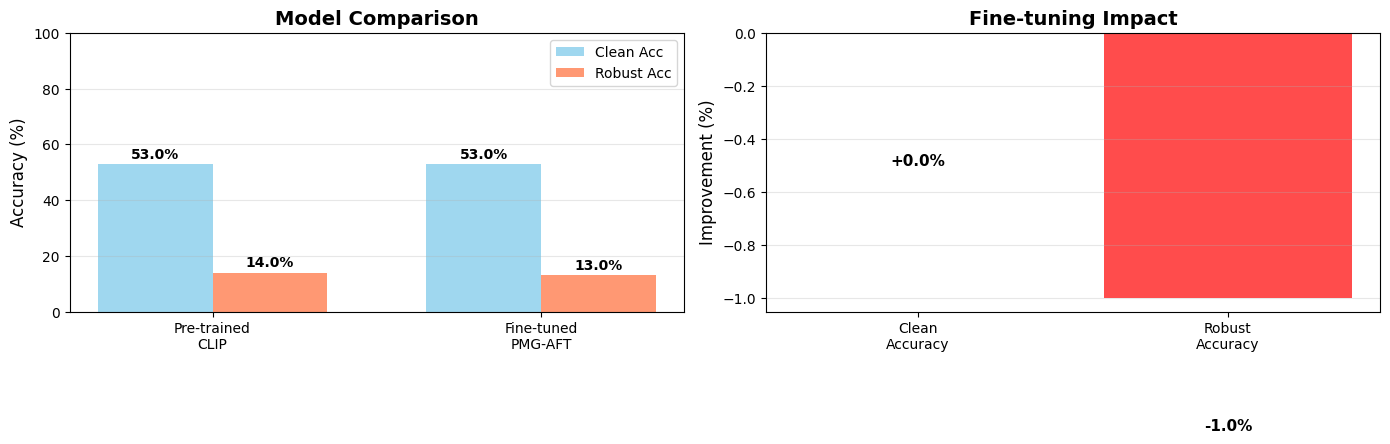

In [16]:
# Prepare data
models_list = ['Pre-trained\nCLIP']
clean_accs = [pretrained_clean]
robust_accs = [pretrained_robust]

if finetuned_model is not None:
    models_list.append('Fine-tuned\nPMG-AFT')
    clean_accs.append(finetuned_clean)
    robust_accs.append(finetuned_robust)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy Comparison
x = np.arange(len(models_list))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, clean_accs, width, label='Clean Acc', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, robust_accs, width, label='Robust Acc', color='coral', alpha=0.8)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models_list)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 100])

# Add value labels
for i, (c, r) in enumerate(zip(clean_accs, robust_accs)):
    ax1.text(i - width/2, c + 2, f'{c:.1f}%', ha='center', fontsize=10, fontweight='bold')
    ax1.text(i + width/2, r + 2, f'{r:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Improvement (if fine-tuned model exists)
ax2 = axes[1]
if finetuned_model is not None:
    improvements = {
        'Clean\nAccuracy': finetuned_clean - pretrained_clean,
        'Robust\nAccuracy': finetuned_robust - pretrained_robust
    }
    
    colors = ['green' if v > 0 else 'red' for v in improvements.values()]
    bars = ax2.bar(improvements.keys(), improvements.values(), color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_ylabel('Improvement (%)', fontsize=12)
    ax2.set_title('Fine-tuning Impact', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (k, v) in enumerate(improvements.items()):
        ax2.text(i, v + 0.5 if v > 0 else v - 0.5, f'{v:+.1f}%', 
                 ha='center', fontsize=11, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'Fine-tuned model\nnot available', 
             ha='center', va='center', fontsize=14, transform=ax2.transAxes)
    ax2.set_xticks([])
    ax2.set_yticks([])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
print("\n💾 Saved: model_comparison.png")
plt.show()

## 7️⃣ Summary

In [17]:
print("\n" + "="*60)
print("📊 FINAL RESULTS")
print("="*60)

# Create results table
print(f"\n{'Model':<25} {'Clean Acc':<15} {'Robust Acc':<15}")
print("-" * 60)
print(f"{'Pre-trained CLIP':<25} {pretrained_clean:>7.2f}%     {pretrained_robust:>7.2f}%")

if finetuned_model is not None:
    print(f"{'Fine-tuned PMG-AFT':<25} {finetuned_clean:>7.2f}%     {finetuned_robust:>7.2f}%")
    print("-" * 60)
    clean_imp = finetuned_clean - pretrained_clean
    robust_imp = finetuned_robust - pretrained_robust
    print(f"{'Improvement':<25} {clean_imp:>+7.2f}%     {robust_imp:>+7.2f}%")
    
    # Key findings
    print("\n" + "="*60)
    print("🎯 Key Findings")
    print("="*60)
    
    if clean_imp > 0:
        print(f"✅ Clean accuracy improved by {clean_imp:.2f}%")
    else:
        print(f"⚠️  Clean accuracy decreased by {abs(clean_imp):.2f}%")
    
    if robust_imp > 0:
        print(f"✅ Robust accuracy improved by {robust_imp:.2f}%")
        print(f"   → {robust_imp/pretrained_robust*100:.1f}% more robust against attacks!")
    else:
        print(f"❌ Robust accuracy decreased by {abs(robust_imp):.2f}%")
    
    print("\n" + "="*60)
else:
    print("\n⚠️  Fine-tuned model not available for comparison")
    print("="*60)

print("\n✅ Evaluation complete!")


📊 FINAL RESULTS

Model                     Clean Acc       Robust Acc     
------------------------------------------------------------
Pre-trained CLIP            53.00%       14.00%
Fine-tuned PMG-AFT          53.00%       13.00%
------------------------------------------------------------
Improvement                 +0.00%       -1.00%

🎯 Key Findings
⚠️  Clean accuracy decreased by 0.00%
❌ Robust accuracy decreased by 1.00%


✅ Evaluation complete!
